# genereative model 

In [1]:
from brian2 import *
%matplotlib inline
from brian2 import SpikeGeneratorGroup
from brian2 import NeuronGroup
import numpy as np
import random
import pandas as pd

INFO       Cache size for target "cython": 1034 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\camil\.cython\brian_extensions" directory. [brian2]


faire un modele generatif où on aurait : 
- une première couche de i neurones = nb de PGs 
- une deuxième couche où on aurait j neurones, connectés à tous les i qui génèrent des PGs en réponse à un spike émit par un i 

on aurait donc {i, j} avec par ex i emet un spike à 10ms et connecte les neurones j1, j3 et j4 qui émettent des spikes à 10ms, 15ms et 6ms respectivement 

-> on définit donc par ti le timing d'occurence d'un PG et par tj le pattern du PG

### variable definition

In [48]:
Ni = 5 #nb de PGs différents
Nj = 10 #nb de N
n_pattern = 10 # nb d'occurrence des PGs 
duration = 10000*msecond

v_r = 1e-322*mV 
tau = 0.001*second 
vi = [-0.07]*int(duration/msecond)*volt

PGs_pattern = {}
PGs_id_tps = {}
detection = {}
state = {}

a = np.arange(Ni)
cmap = plt.cm.get_cmap("plasma")
color_dict = pd.Series({i:cmap(i/len(a)) for i,k in enumerate(a)})

In [3]:
# --- def du moment d'occurence des PGs -------------------------------------------------------------------------------------------------

i_indices = np.random.randint(0, Ni, size = n_pattern) # nombre de PG observé (n_pattern), de Ni sortes différentes
i_temps = np.random.uniform(0, duration, size = n_pattern)*second # temps d'occurence des n_pattern PG 


# --- def des projections des neurones pré-syn (i.e. des des PGs) -----------------------------------------------------------------------

i_syn=[]
n_syn = []

for k in range(Ni) : 
    n_j = np.random.randint(3, Nj, size = 1) # nombre de neurone qu'un Ni va connecter : au moins 3 neurones impliqués dans un PG
    i_syn.append(random.sample(range(Nj), int(n_j))) # def des j connectés aux i, pas de repetition (pas de delais heterosynaptique)
    n_syn.append(len(i_syn[k])) # def du nb de synapses pour set des poids et délais aléatoires, voir ci-après 

n_syn = sum(n_syn) 


# --- def des poids et delais synaptiques -----------------------------------------------------------------------------------------------

weight = np.random.rand(n_syn)
delay = np.random.rand(n_syn)*0.1*second # là entre 0 et 100 -> 144 

### NN simulation for PGs generation and detection

In [102]:
for i in range(n_pattern) :
    
    a = SpikeGeneratorGroup(Ni, [i_indices[i]], [i_temps[i]/ms*msecond])
    a_spike= SpikeMonitor(a)
    
    
    b = NeuronGroup(Nj, 
                    ''' dv/dt = -v/tau : volt
                        tau : second''',
                    threshold= 'v > 0.02*volt',
                    reset= 'v = v_r')
    b.v = v_r
    b.tau = tau
    b_spike = SpikeMonitor(b)
    b_state = StateMonitor(b, 'v', record = True)
    

    s = Synapses(a,b, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    
    for k in range(Ni):
        s.connect(i = k , j = i_syn[k])
        
    s.w[:,:] = weight*10
    s.delay[:,:] = delay
    
    
    c =  NeuronGroup(Ni, 
                    ''' dv/dt = -v/tau : volt
                        tau : second''',
                    threshold= 'v > 0.01*volt',
                    reset= 'v = v_r',
                    method = 'exact')
    c.v = v_r
    c.tau = tau
    c_spike = SpikeMonitor(c)

    
    syn = Synapses(b,c, on_pre='v+=(0.01*volt*w)', model = 'w:1')
    for k in range(Ni):
        syn.connect(i = i_syn[k], j = k)         
    syn.w[:,:] = weight
    #syn.delay[:,:] = delay
    for toto in range(Ni) :
        syn.delay[:,[toto]] = max(s.delay[toto,:])-s.delay[toto,:]
    
    
    run(duration) 
    
    state[i] = (b_state.t, b_state.v)
    PGs_id_tps[i] = (a_spike.t, a_spike.i)
    PGs_pattern[i] = (b_spike.t, b_spike.i) # je vourdrais avoir l'echelle de temps en ms et non en s 
    detection[i] = (c_spike.t, c_spike.i) 

In [51]:
def visualise_connectivity(s): # ajouter les delays
    Ns = len(s.source)
    Nt = len(s.target)
    figure(figsize=(15,8))
    
    subplot(141)
    plot(zeros(Ns), arange(Ns), 'ok', ms=7)
    plot(ones(Nt), arange(Nt), 'ok', ms=7)
    for i, j in zip(s.i, s.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    
    subplot(142)
    plot(s.i, s.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(143) 
    scatter(s.i, s.j, s.w*30 )
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    subplot(144) 
    scatter(s.i, s.j, s.delay*70)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

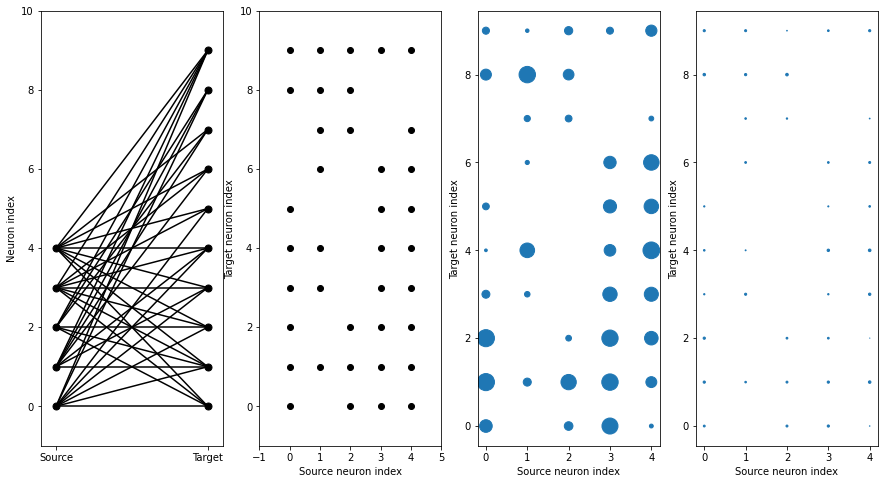

In [52]:
visualise_connectivity(s)

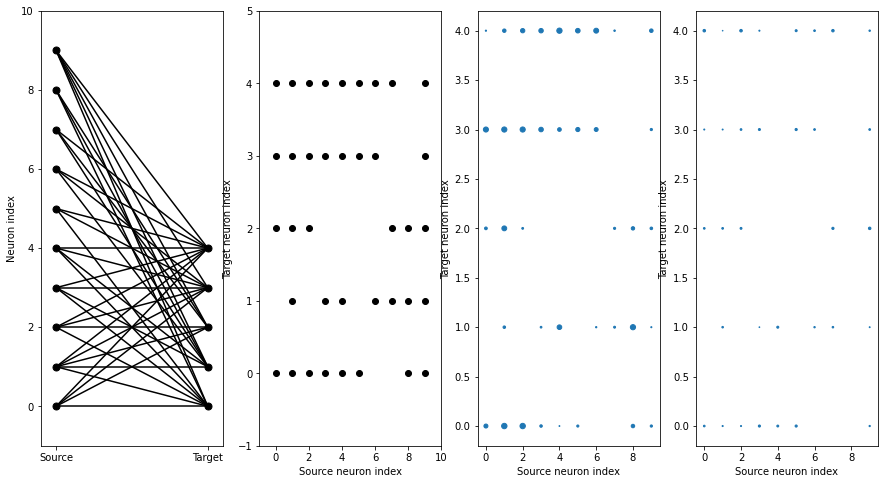

In [53]:
visualise_connectivity(syn)

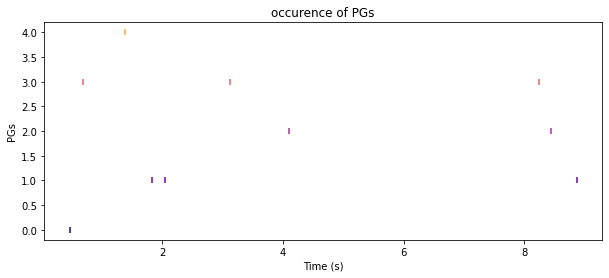

In [56]:
plt.figure(figsize=(10,4))
for i in range(n_pattern) :
    plt.scatter(PGs_id_tps[i][0], PGs_id_tps[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('PGs')
    title('occurence of PGs')

In [92]:
PGs_id_tps

{0: (<spikemonitor_1.t: array([1.8416]) * second>,
  <spikemonitor_1.i: array([1])>),
 1: (<spikemonitor_3.t: array([8.2466]) * second>,
  <spikemonitor_3.i: array([3])>),
 2: (<spikemonitor_2.t: array([1.3939]) * second>,
  <spikemonitor_2.i: array([4])>),
 3: (<spikemonitor.t: array([8.8709]) * second>, <spikemonitor.i: array([1])>),
 4: (<spikemonitor_1.t: array([2.0497]) * second>,
  <spikemonitor_1.i: array([1])>),
 5: (<spikemonitor_3.t: array([3.1193]) * second>,
  <spikemonitor_3.i: array([3])>),
 6: (<spikemonitor_2.t: array([4.1065]) * second>,
  <spikemonitor_2.i: array([2])>),
 7: (<spikemonitor.t: array([0.4684]) * second>, <spikemonitor.i: array([0])>),
 8: (<spikemonitor_1.t: array([8.4397]) * second>,
  <spikemonitor_1.i: array([2])>),
 9: (<spikemonitor_3.t: array([0.6831]) * second>,
  <spikemonitor_3.i: array([3])>)}

In [94]:
PGs_pattern[6]

(<spikemonitor_3.t: array([4.1135, 4.1606, 4.1624, 4.2029]) * second>,
 <spikemonitor_3.i: array([9, 1, 0, 8])>)

In [95]:
syn.w[:,2]

array([0.22562706, 0.38234493, 0.10962642, 0.78092271, 0.15350707,
       0.24844856])

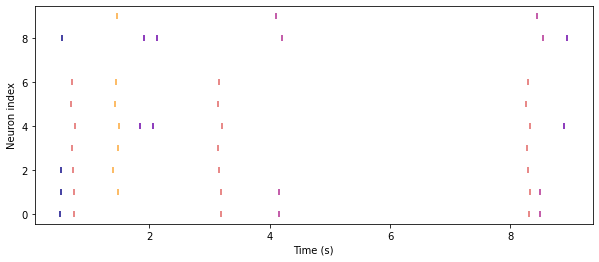

In [57]:
id = []
plt.figure(figsize=(10,4))
for i in range(n_pattern) :
    plt.scatter(PGs_pattern[i][0], PGs_pattern[i][1], color = color_dict[i_indices[i]], marker = "|")
    id.append(PGs_pattern[i][1])
    xlabel('Time (s)')
    ylabel('Neuron index');

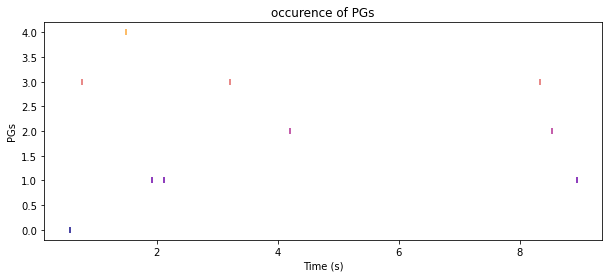

In [103]:
plt.figure(figsize=(10,4))
for i in range(n_pattern) :
    plt.scatter(detection[i][0], detection[i][1], color = color_dict[i_indices[i]], marker = "|")
    xlabel('Time (s)')
    ylabel('PGs')
    title('occurence of PGs')

In [20]:
for i in range(n_pattern) : 
    print(detection[i])

(<spikemonitor_2.t: array([], dtype=float64) * second>, <spikemonitor_2.i: array([], dtype=int32)>)
(<spikemonitor_1.t: array([], dtype=float64) * second>, <spikemonitor_1.i: array([], dtype=int32)>)
(<spikemonitor.t: array([], dtype=float64) * second>, <spikemonitor.i: array([], dtype=int32)>)
(<spikemonitor_3.t: array([], dtype=float64) * second>, <spikemonitor_3.i: array([], dtype=int32)>)
(<spikemonitor_2.t: array([], dtype=float64) * second>, <spikemonitor_2.i: array([], dtype=int32)>)
(<spikemonitor_1.t: array([], dtype=float64) * second>, <spikemonitor_1.i: array([], dtype=int32)>)
(<spikemonitor.t: array([], dtype=float64) * second>, <spikemonitor.i: array([], dtype=int32)>)
(<spikemonitor_3.t: array([], dtype=float64) * second>, <spikemonitor_3.i: array([], dtype=int32)>)
(<spikemonitor_2.t: array([], dtype=float64) * second>, <spikemonitor_2.i: array([], dtype=int32)>)
(<spikemonitor_1.t: array([], dtype=float64) * second>, <spikemonitor_1.i: array([], dtype=int32)>)


In [21]:
for i in range(Ni) : 
    print(s.delay[i,:])
    print(len(s.delay[i,:]))

[34.91725889 23.65877451 48.87636081 88.17907342 72.13941103 71.19359283
 22.38618411 64.81867098] ms
8
[36.21960051 64.07980925 59.61682176 12.24745647 45.08745187 71.96071302
 36.43390236] ms
7
[ 6.91828527 96.2521351  44.48207697 53.95077376 26.25946576 55.75554156] ms
6
[42.14995814 71.4979078  42.88573684 16.93774034 42.07811398 26.3354046
 69.16026076 84.91464485] ms
8
[ 1.68543919 79.97120103  8.7635769  66.81601958 91.26583254  3.87081162
 56.28703135 96.80580006 38.43826883] ms
9


In [22]:
for i in range(Ni): 
    print(syn.delay[:,i])
    print(len(syn.delay[:,i]))

[53.26181453 64.52029891 39.30271261  0.         16.03966239 16.98548059
 65.79288931 23.36040244] ms
8
[35.74111252  7.88090378 12.34389127 59.71325656 26.87326115  0.
 35.52681067] ms
7
[89.33384983  0.         51.77005812 42.30136133 69.99266934 40.49659354] ms
6
[42.76468671 13.41673705 42.02890801 67.97690451 42.83653088 58.57924025
 15.7543841   0.        ] ms
8
[95.12036088 16.83459903 88.04222316 29.98978049  5.53996752 92.93498844
 40.51876871  0.         58.36753123] ms
9


In [23]:
for i in range(Nj) : 
    print(syn.delay[i,:])

[39.30271261 40.49659354 15.7543841  92.93498844] ms
[16.98548059 35.74111252 42.30136133 13.41673705  5.53996752] ms
[16.03966239 51.77005812 42.02890801 95.12036088] ms
[64.52029891  7.88090378 58.57924025 16.83459903] ms
[53.26181453 59.71325656  0.          0.        ] ms
[65.79288931 67.97690451 58.36753123] ms
[26.87326115 42.76468671 40.51876871] ms
[35.52681067 69.99266934 88.04222316] ms
[0. 0. 0.] s
[23.36040244 12.34389127 89.33384983 42.83653088 29.98978049] ms


In [24]:
for i in range(n_pattern) : 
    print(PGs_pattern[i][0])

<spikemonitor_1.t: array([1.8539, 1.8779, 1.8781, 1.9137]) * second>
<spikemonitor.t: array([8.2636, 8.273 , 8.2888, 8.2888, 8.2896, 8.3159, 8.3182, 8.3316]) * second>
<spikemonitor_3.t: array([1.3957, 1.4324, 1.4503, 1.4608, 1.474 , 1.4853, 1.4908]) * second>
<spikemonitor_2.t: array([8.8832, 8.9072, 8.9074, 8.943 ]) * second>
<spikemonitor_1.t: array([2.062 , 2.086 , 2.0862, 2.1218]) * second>
<spikemonitor.t: array([3.1363, 3.1457, 3.1615, 3.1615, 3.1623, 3.1886, 3.1909, 3.2043]) * second>
<spikemonitor_3.t: array([4.1135, 4.1329, 4.1606, 4.1624, 4.2029]) * second>
<spikemonitor_2.t: array([0.4909, 0.4922, 0.5174, 0.5333, 0.5397, 0.5406, 0.5567]) * second>
<spikemonitor_1.t: array([8.4467, 8.4661, 8.4938, 8.4956, 8.5361]) * second>
<spikemonitor.t: array([0.7001, 0.7095, 0.7253, 0.7253, 0.7261, 0.7524, 0.7547, 0.7681]) * second>


# unsupervised recognition of PGs

## detection of temporal patterns 

In [25]:
# obtenir le temps et l'indice de chaque spike, dans l'ordre d'apparition, indépendemment du PGs auquel il appartient, en grandeur ms (mais sans unité de temps) et int
all_spike_time = []

for k in range(n_pattern) :
    for i in range(len(PGs_pattern[k][1])):
        all_spike_time.append(tuple((round(PGs_pattern[k][0][i]*1000/second), PGs_pattern[k][1][i])))
        
all_spike_time.sort(key=lambda y: y[0]) #pour trier de tmin à tmax

In [26]:
all_spike_time

[(491, 5),
 (492, 3),
 (517, 0),
 (533, 9),
 (540, 1),
 (541, 2),
 (557, 8),
 (700, 5),
 (710, 3),
 (725, 6),
 (725, 9),
 (726, 2),
 (752, 0),
 (755, 1),
 (768, 4),
 (1396, 2),
 (1432, 5),
 (1450, 6),
 (1461, 9),
 (1474, 3),
 (1485, 1),
 (1491, 4),
 (1854, 4),
 (1878, 1),
 (1878, 7),
 (1914, 8),
 (2062, 4),
 (2086, 1),
 (2086, 7),
 (2122, 8),
 (3136, 5),
 (3146, 3),
 (3162, 6),
 (3162, 9),
 (3162, 2),
 (3189, 0),
 (3191, 1),
 (3204, 4),
 (4114, 9),
 (4133, 7),
 (4161, 1),
 (4162, 0),
 (4203, 8),
 (8264, 5),
 (8273, 3),
 (8289, 6),
 (8289, 9),
 (8290, 2),
 (8316, 0),
 (8318, 1),
 (8332, 4),
 (8447, 9),
 (8466, 7),
 (8494, 1),
 (8496, 0),
 (8536, 8),
 (8883, 4),
 (8907, 1),
 (8907, 7),
 (8943, 8)]

In [27]:
temps_tot

NameError: name 'temps_tot' is not defined

In [ ]:
# def de ma fenetre temporelle pour reconnaître les PGs
temps_tot = int(duration/msecond)
t_window = 200 #ms
nb_wind = int(temps_tot/t_window)
X = np.zeros((nb_wind, Nj, t_window))

In [ ]:
for k in range(nb_wind) :
    for t,i in (all_spike_time) : 
        if t<t_window : 
            X[1][i][t] = 1 #on peut faire [1,i,t]
            print('ok')
        if t_window*(k-1)<t<t_window*k : 
            X[k][i][t-t_window*(k-1)] = 1 
            print('okk')

In [ ]:
X[58]

In [ ]:
plot(X[58].T)

In [ ]:
all_spike_time

## cam's k-means